<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_XGBOOSTpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------------------------------
# LANGKAH 1: INSTAL & IMPORT LIBRARY
# -----------------------------------------------------
!pip install xgboost

import os
import joblib
import numpy as np
import xgboost as xgb
from google.colab import drive

# Import dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder  # Hanya untuk label
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN LOAD DATA
# -----------------------------------------------------

# Path tempat Anda menyimpan file .joblib
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'
PATH_X = os.path.join(BASE_DIR, 'features_X.joblib')
PATH_Y = os.path.join(BASE_DIR, 'labels_y.joblib')

print("Memuat data yang telah diproses...")

# Cek apakah file ada
if not os.path.exists(PATH_X) or not os.path.exists(PATH_Y):
    print(f"Error: File 'features_X.joblib' atau 'labels_y.joblib' tidak ditemukan di {BASE_DIR}")
    print("Pastikan Anda sudah menjalankan skrip preprocessing terlebih dahulu.")
else:
    X = joblib.load(PATH_X)
    y = joblib.load(PATH_Y)

    print(f"Data berhasil dimuat.")
    print(f"Bentuk (shape) X: {X.shape}")
    print(f"Bentuk (shape) y: {y.shape}")

Memuat data yang telah diproses...
Data berhasil dimuat.
Bentuk (shape) X: (1651, 436)
Bentuk (shape) y: (1651,)


In [ ]:
    # -----------------------------------------------------
    # LANGKAH 3: ENCODE LABEL DAN BAGI DATA
    # -----------------------------------------------------

    # Model ML memerlukan angka, bukan string '1000', '2000'
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Simpan nama kelas untuk laporan nanti
    class_names = le.classes_
    num_classes = len(class_names)
    print(f"\nLabel berhasil di-encode. Jumlah kelas: {num_classes}. Kelas: {class_names}")

    # Simpan LabelEncoder! Ini SANGAT PENTING untuk Flask
    # agar bisa mengubah prediksi angka (misal: 0) kembali ke '1000'
    le_path = os.path.join(BASE_DIR, 'label_encoder.joblib')
    joblib.dump(le, le_path)
    print(f"LabelEncoder disimpan di: {le_path}")

    # Bagi data menjadi training (80%) dan testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,    # 20% untuk data tes
        random_state=42,  # Agar hasil pembagian selalu sama
        stratify=y_encoded
    )

    print(f"Data dibagi:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")


Label berhasil di-encode. Jumlah kelas: 7. Kelas: ['1000' '10000' '100000' '2000' '20000' '5000' '50000']
LabelEncoder disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/label_encoder.joblib
Data dibagi:
X_train shape: (1320, 436)
X_test shape: (331, 436)


In [ ]:
    # -----------------------------------------------------
    # LANGKAH 4: PREPROCESSING MODEL (SCALING)
    # -----------------------------------------------------

    print("\nLANGKAH 4: Preprocessing Model")
    print("Model berbasis pohon (XGBoost) tidak sensitif terhadap skala fitur.")
    print("Oleh karena itu, langkah StandardScaler DILEWATI.")

    # Tidak seperti SVM, kita bisa langsung menggunakan X_train dan X_test
    X_train_processed = X_train
    X_test_processed = X_test



LANGKAH 4: Preprocessing Model
Model berbasis pohon (XGBoost) tidak sensitif terhadap skala fitur.
Oleh karena itu, langkah StandardScaler DILEWATI.


In [ ]:
    # -----------------------------------------------------
    # LANGKAH 5: HYPERPARAMETER TUNING (GRIDSEARCHCV)
    # -----------------------------------------------------

    print("\nMemulai Hyperparameter Tuning untuk XGBoost...")
    print("Ini mungkin memakan waktu beberapa menit...")

    # Buat model dasar XGBoost
    # Kita perlu memberi tahu objective dan jumlah kelas
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Karena kita punya > 2 kelas
        num_class=num_classes,      # Jumlah kelas dari LabelEncoder
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Tentukan parameter yang ingin diuji
    # Ini adalah set parameter yang lebih kecil agar berjalan cepat di Colab
    # n_estimators: Jumlah pohon
    # max_depth: Kedalaman maksimum pohon
    # learning_rate: Seberapa cepat model belajar
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.01]
    }

    # cv=3 artinya 3-fold cross-validation
    # n_jobs=-1 menggunakan semua CPU
    grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    # Latih GridSearchCV
    grid.fit(X_train_processed, y_train)


Memulai Hyperparameter Tuning untuk XGBoost...
Ini mungkin memakan waktu beberapa menit...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=7, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             verbose=2)


Tuning selesai!
Parameter terbaik yang ditemukan: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

--- Laporan Klasifikasi XGBoost ---
              precision    recall  f1-score   support

        1000       1.00      0.94      0.97        48
       10000       1.00      1.00      1.00        48
      100000       0.98      0.96      0.97        48
        2000       0.98      1.00      0.99        48
       20000       1.00      1.00      1.00        48
        5000       0.96      1.00      0.98        45
       50000       0.98      1.00      0.99        46

    accuracy                           0.98       331
   macro avg       0.98      0.99      0.98       331
weighted avg       0.99      0.98      0.98       331

Akurasi Keseluruhan: 98.49%

--- Confusion Matrix ---


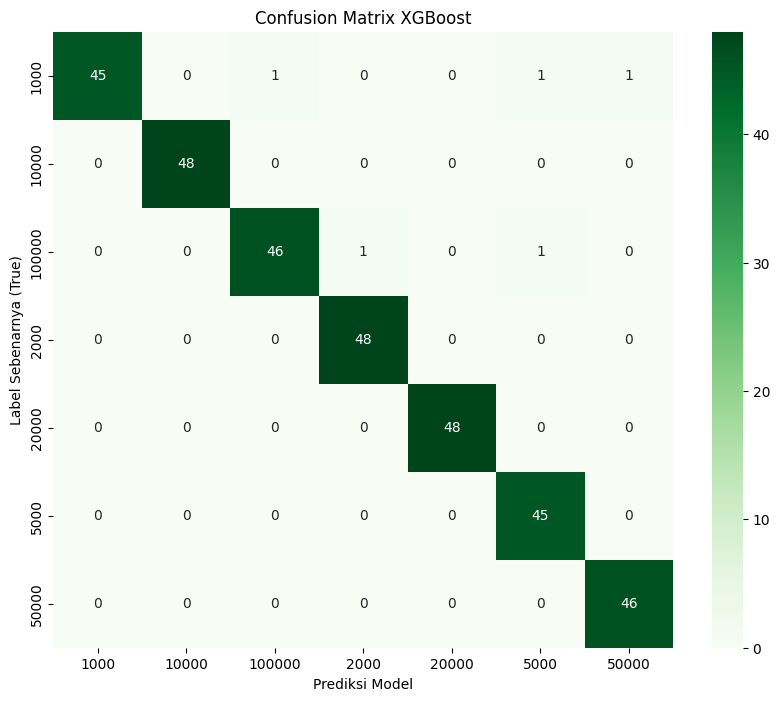

In [ ]:
    # -----------------------------------------------------
    # LANGKAH 6: EVALUASI MODEL
    # -----------------------------------------------------

    print("\nTuning selesai!")

    # Tampilkan parameter terbaik yang ditemukan
    print(f"Parameter terbaik yang ditemukan: {grid.best_params_}")

    # 'grid' sekarang adalah model XGBoost terbaik Anda
    best_xgb = grid.best_estimator_

    # Lakukan prediksi pada data tes
    y_pred = best_xgb.predict(X_test_processed)

    # Tampilkan laporan evaluasi
    print("\n--- Laporan Klasifikasi XGBoost ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Tampilkan akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi Keseluruhan: {accuracy * 100:.2f}%")

    # Tampilkan Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',  # Ganti cmap agar beda
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Sebenarnya (True)')
    plt.title('Confusion Matrix XGBoost')
    plt.show()

In [ ]:
    # -----------------------------------------------------
    # LANGKAH 7: SIMPAN MODEL XGBOOST TERLATIH
    # -----------------------------------------------------

    model_path = os.path.join(BASE_DIR, 'xgboost_model.joblib')
    joblib.dump(best_xgb, model_path)

    print(f"\nModel XGBoost terbaik berhasil disimpan di: {model_path}")
    print("Proses selesai.")


Model XGBoost terbaik berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/xgboost_model.joblib
Proses selesai.
